In [1]:
import pandas as pd
from pathlib import Path
import re
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

plt.style.use('ggplot')

In [2]:
CSV_PATHS = 'https://scandeval.com/{language}-nlg.csv'
#CSV_PATHS = str(Path.home() / "gitsky" / "scandeval.com" / "{language}-nlg-test.csv")
CSV_PATHS

'https://scandeval.com/{language}-nlg.csv'

In [3]:
gpt4_models = {
    "gpt-4-0613": "gpt-4",
    "gpt-4-1106-preview": "gpt-4-turbo",
    "gpt-4o-2024-05-13": "gpt-4o",
}
llama_models = {
    "meta-llama/Llama-2-70b-hf": "llama-2-70b",
    "meta-llama/Meta-Llama-3-70B": "llama-3-70b",
}

all_models = list(gpt4_models.keys()) + list(llama_models.keys())
all_new_models = list(gpt4_models.values()) + list(llama_models.values())

results_dict = dict()
for language in ['danish', 'norwegian', 'swedish', 'german', 'dutch', 'english', 'icelandic']:
    df = (
        pd
        .read_csv(CSV_PATHS.format(language=language))
        .query('merge == False')
        .set_index('model_id')
    )
    df.index = df.index.map(lambda x: re.sub('\(.*\)', '', x).strip())
    scores = df['rank']

    for model in gpt4_models:
        if model not in scores:
            scores.loc[model] = scores.loc[list(gpt4_models.keys())[0]]
            
    for model in llama_models:
        if model not in scores:
            scores.loc[model] = scores.loc[list(llama_models.keys())[0]]
            
    scores = scores.loc[all_models]
    results_dict[language] = scores.tolist()

df = pd.DataFrame(results_dict, index=all_new_models)
df

,danish,norwegian,swedish,german,dutch,english,icelandic
gpt-4,1.12,1.17,1.10,1.18,1.14,1.22,1.54
gpt-4-turbo,1.20,1.26,1.19,1.33,1.45,1.16,1.19
gpt-4o,1.23,1.31,1.18,1.44,1.54,1.36,1.17
llama-2-70b,1.73,2.25,1.85,1.71,2.15,1.54,3.32
llama-3-70b,1.46,1.45,1.38,1.36,1.34,1.33,2.45


In [4]:
gpt4_values = df.loc[list(gpt4_models.values())[0]]
gpt4_values

danish       1.12
norwegian    1.17
swedish      1.10
german       1.18
dutch        1.14
english      1.22
icelandic    1.54
Name: gpt-4, dtype: float64

In [5]:
gpt4_df = df.loc[list(gpt4_models.values())]
gpt4_df = gpt4_values - gpt4_df
gpt4_df

,danish,norwegian,swedish,german,dutch,english,icelandic
gpt-4,0.00,0.00,0.00,0.00,0.00,0.00,0.00
gpt-4-turbo,-0.08,-0.09,-0.09,-0.15,-0.31,0.06,0.35
gpt-4o,-0.11,-0.14,-0.08,-0.26,-0.40,-0.14,0.37


In [6]:
llama_df = df.loc[list(llama_models.values())]
llama_df = gpt4_values - llama_df
llama_df

,danish,norwegian,swedish,german,dutch,english,icelandic
llama-2-70b,-0.61,-1.08,-0.75,-0.53,-1.01,-0.32,-1.78
llama-3-70b,-0.34,-0.28,-0.28,-0.18,-0.20,-0.11,-0.91


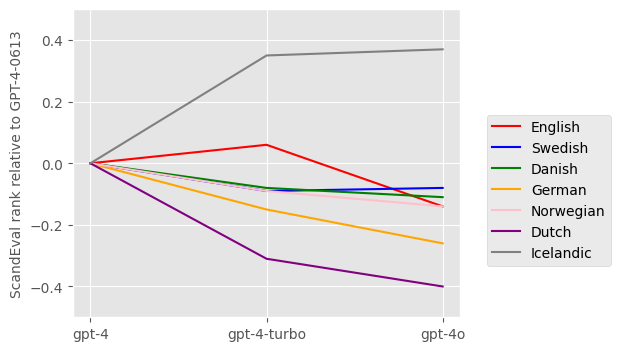

In [7]:
#fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))
plt.figure(figsize=(5,4))

plt.plot(gpt4_df.english, label="English", color='red')
plt.plot(gpt4_df.swedish, label="Swedish", color='blue')
plt.plot(gpt4_df.danish, label="Danish", color='green')
plt.plot(gpt4_df.german, label="German", color='orange')
plt.plot(gpt4_df.norwegian, label="Norwegian", color='pink')
plt.plot(gpt4_df.dutch, label="Dutch", color='purple')
plt.plot(gpt4_df.icelandic, label="Icelandic", color='gray')
plt.ylim(-0.5, 0.5)

# ax[1].plot(llama_df.english, color='red')
# ax[1].plot(llama_df.swedish, color='blue')
# ax[1].plot(llama_df.danish, color='green')
# ax[1].plot(llama_df.german, color='orange')
# ax[1].plot(llama_df.norwegian, color='pink')
# ax[1].plot(llama_df.dutch, color='purple')
# ax[1].plot(llama_df.icelandic, color='gray')
# ax[1].set_ylim(-0.5, 0.1)

plt.ylabel('ScandEval rank relative to GPT-4-0613', fontsize=10)
plt.legend(bbox_to_anchor=(1.05, 0.68))

plt.savefig('gpt4-drop.png', bbox_inches="tight", dpi=300)
plt.show()